# FastText

In [ ]:
!pip install fasttext

In [2]:
import fasttext

prepare already generated data

In [3]:
def remove_prefixes(strings):
    prefixes = ['a', 'an', 'the']
    result = []

    for string in strings:
        words = string.split()
        if words[0].lower() in prefixes:
            result.append(' '.join(words[1:]))
        else:
            result.append(string)

    return result

In [4]:
save_classes = "data/all_classes.txt"
save_concepts = "data/all_concepts.txt"

with open(save_classes, "r") as f:
    classes = f.read().lower().split("\n")

with open(save_concepts, "r") as f:
    concepts = f.read().lower().split("\n")

concepts = remove_prefixes(concepts)
vocab = classes + concepts

unique = []
for item in vocab:
  if item not in unique:
    unique.append(item)

vocab = unique

In [5]:
with open("vocab.txt", "w") as f:
    f.write(vocab[0])
    for word in vocab[1:]:
      f.write("\n" + word)

train fasttext on our vocab of classes and concepts

In [6]:
test_model = fasttext.train_supervised("vocab.txt")

implement out cosine similarity function from scratch

In [7]:
import numpy as np

def cos_sim(vec1: np.ndarray, vec2: np.ndarray, eps = 1e-8):
  nom = np.dot(vec1, vec2)
  denom = np.linalg.norm(vec1) * np.linalg.norm(vec2) + eps
  return nom / denom

In [8]:
class_vectors = {}
for label in classes:
  class_vectors.update({label: test_model[label]})

here is a simple test example

In [9]:
subset = ["wings", "fuselage"]
best_similarity = -1
predicted_class = None

for class_label, class_vector in class_vectors.items():
    similarity = cos_sim(class_vectors[class_label], np.mean([test_model[concept] for concept in subset], axis=0))

    if similarity > best_similarity:
        best_similarity = similarity
        predicted_class = class_label

print("Predicted Class Label:", predicted_class)

Predicted Class Label: sweatshirt


good!
let's test fasttex in more complicated task

In [ ]:
!pip install open_clip_torch
!pip install -U sentence-transformers
!pip install openai-clip
!pip install pytorchcv
!pip install -q git+https://github.com/huggingface/peft.git git+https://github.com/huggingface/transformers.git
!pip install accelerate
!pip install bitsandbytes
!pip install sentencepiece
!pip install datasets
!pip install nltk

In [11]:
import open_clip
import clip
from torchvision.datasets import CIFAR10
from open_clip import tokenizer
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import requests
import json
import math
import random
from tqdm import tqdm
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [12]:
clip_model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-16', pretrained='openai')

100%|███████████████████████████████████████| 351M/351M [00:26<00:00, 13.4MiB/s]


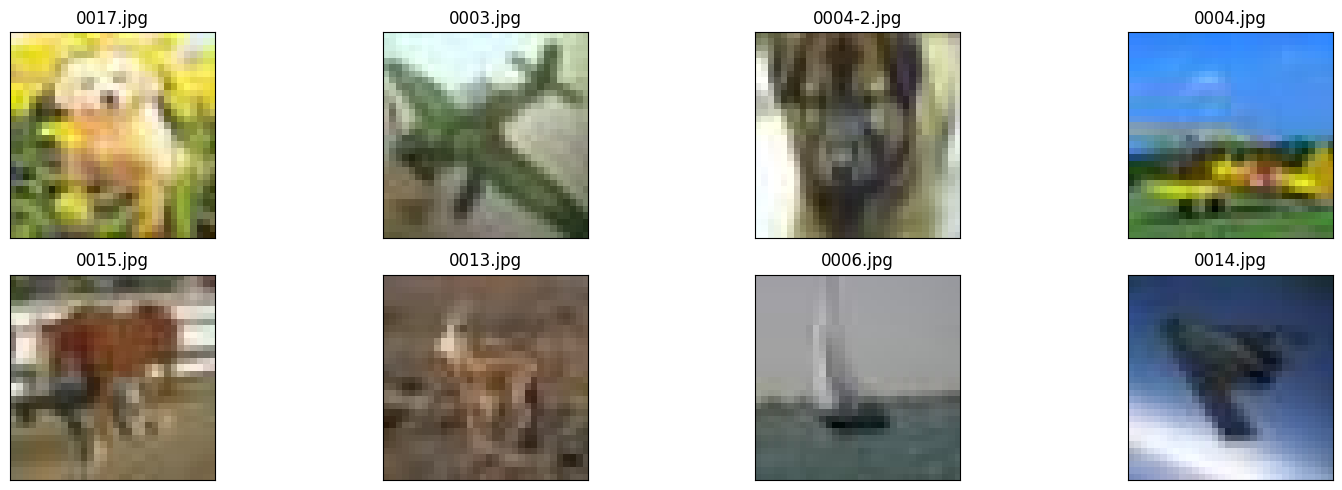

In [13]:
original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))

for filename in [filename for filename in os.listdir("/content/") if filename.endswith(".png") or filename.endswith(".jpg")]:
    image = Image.open(os.path.join("/content/", filename)).convert("RGB")

    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}")
    plt.xticks([])
    plt.yticks([])

    images.append(preprocess(image))
    original_images.append(image)

plt.tight_layout()

In [20]:
import torch.functional as F

In [14]:
image_input = torch.tensor(np.stack(images))

with torch.no_grad():
    image_features = clip_model.encode_image(image_input).float()

image_features /= image_features.norm(dim=-1, keepdim=True)

In [15]:
text_tokens = tokenizer.tokenize(concepts)

with torch.no_grad():
    text_features = clip_model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

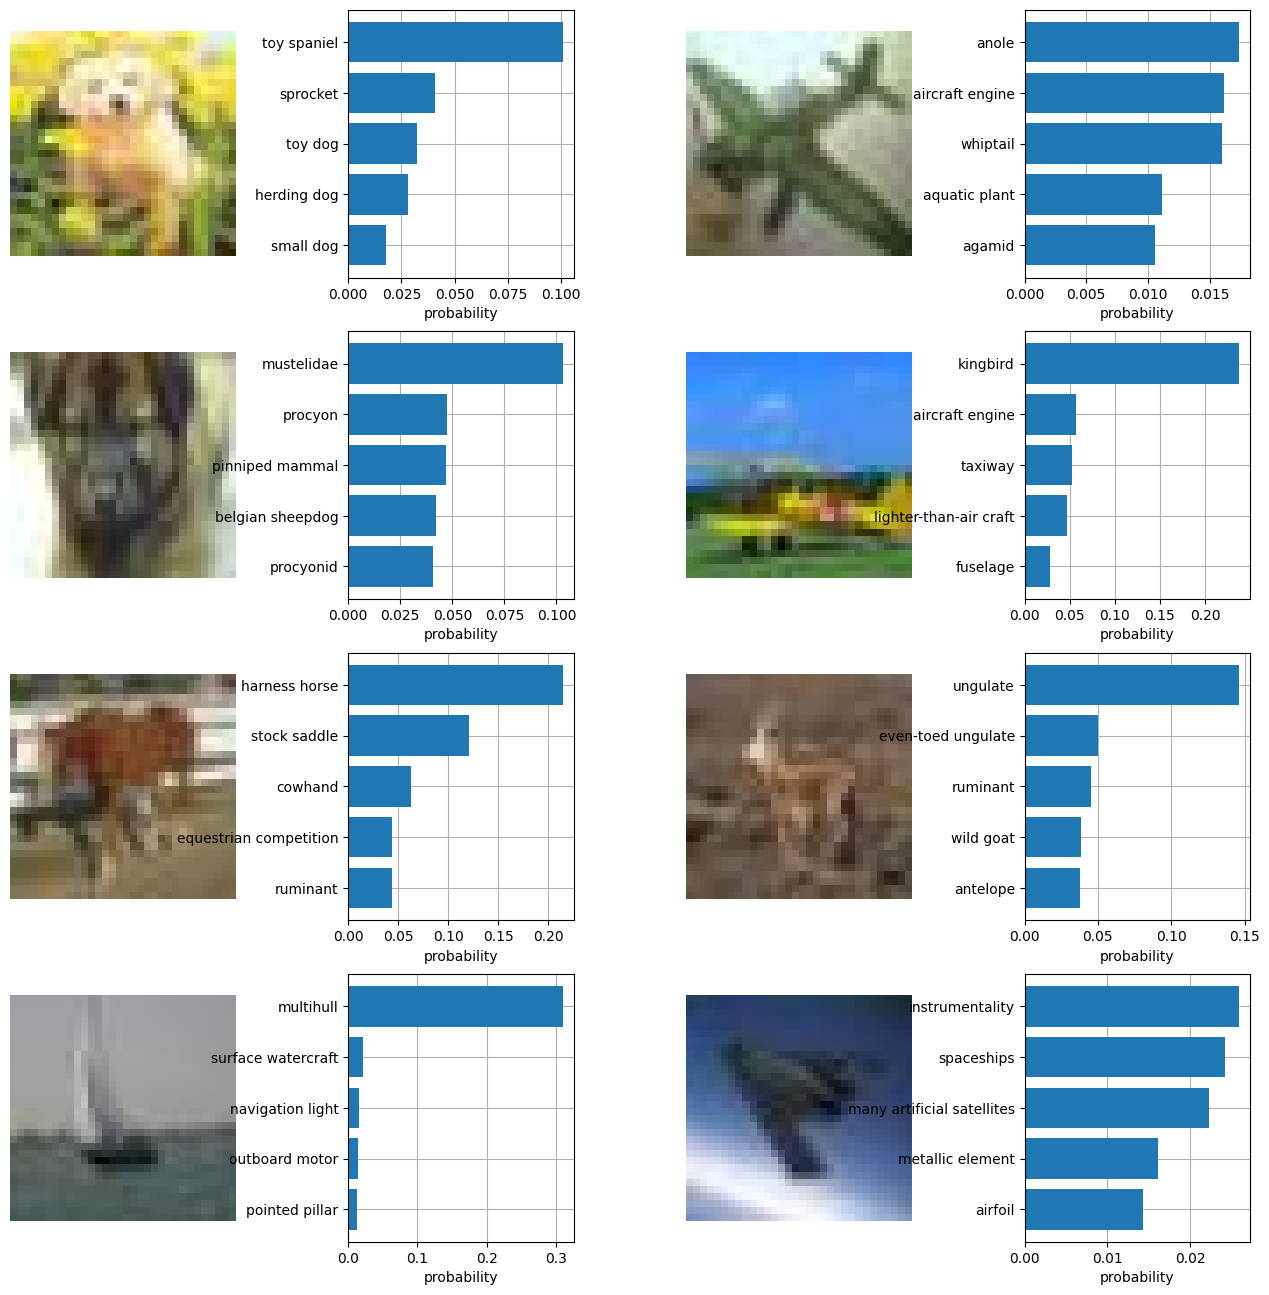

In [17]:
plt.figure(figsize=(16, 16))

for i, image in enumerate(original_images):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [concepts[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()

In [18]:
cifar10_classes = classes[:10]

cifar10_class_vectors = {}
for label in cifar10_classes:
  cifar10_class_vectors.update({label: test_model[label]})

In [19]:
for i, image in enumerate(original_images):

  best_similarity = -1
  predicted_class = None
  image_concepts = [concepts[index] for index in top_labels[i].numpy()]

  for class_label, class_vector in cifar10_class_vectors.items():
      similarity = cos_sim(class_vectors[class_label], np.mean([test_model[concept] for concept in image_concepts], axis=0))

      if similarity > best_similarity:
          best_similarity = similarity
          predicted_class = class_label

  print(predicted_class)

ship
horse
automobile
dog
cat
automobile
frog
dog


In [21]:
image_concepts

['instrumentality',
 'spaceships',
 'many artificial satellites',
 'metallic element',
 'airfoil']

In [22]:
for class_label, class_vector in cifar10_class_vectors.items():
    similarity = cos_sim(class_vectors[class_label], np.mean([test_model[concept] for concept in image_concepts], axis=0))

    if similarity > best_similarity:
        best_similarity = similarity
        predicted_class = class_label

print(predicted_class)

dog


# via descriptions

In [ ]:
!pip install git+https://github.com/openai/CLIP.git
!pip install git+https://github.com/modestyachts/ImageNetV2_pytorch

In [ ]:
!git clone https://github.com/sachit-menon/classify_by_description_release

In [ ]:
!pip install opendatasets
!pip install pandas

In [7]:
import opendatasets as od
import pandas

od.download(
    "https://www.kaggle.com/datasets/vitaliykinakh/stable-imagenet1k")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: andron00e
Your Kaggle Key: ··········


100%|██████████| 9.80G/9.80G [01:25<00:00, 123MB/s]


In [8]:
od.download("https://www.kaggle.com/datasets/wenewone/cub2002011")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: andron00e
Your Kaggle Key: ··········


100%|██████████| 1.49G/1.49G [00:14<00:00, 109MB/s]


In [9]:
od.download("https://www.kaggle.com/datasets/whilefalse/momoda")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: andron00e
Your Kaggle Key: ··········


100%|██████████| 9.04G/9.04G [01:19<00:00, 122MB/s]


In [45]:
%cd classify_by_description_release

/content/classify_by_description_release


In [ ]:
!pip install pytorch torchvision
!pip install matplotlib torchmetrics

In [47]:
!python main.py

Creating descriptors...

Example description for class Black-footed Albatross: "Black-footed Albatross, which is a seabird"

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loading model...
Encoding descriptions...
Evaluating...
100% 10/10 [00:18<00:00,  1.87s/it]




Total Description-based Top-1 Accuracy:  53.158438205718994
Total Description-based Top-5 Accuracy:  84.20780301094055
Total CLIP-Standard Top-1 Accuracy:  52.07110643386841
Total CLIP-Standard Top-5 Accuracy:  82.61995315551758


In [48]:
!python load.py

Creating descriptors...

Example description for class Black-footed Albatross: "Black-footed Albatross, which is a seabird"

Traceback (most recent call last):
  File "/content/classify_by_description_release/load.py", line 291, in <module>
    show_from_indices(torch.where(descr_predictions != clip_predictions)[0], images, labels, descr_predictions, clip_predictions, image_description_similarity=image_description_similarity, image_labels_similarity=image_labels_similarity)
NameError: name 'descr_predictions' is not defined
